# Assignment 3: Stance Detections

    Group 35: Kinga Jenei and Jonna Marie Matthiesen

In [ ]:
# imports

import numpy as np
import pandas as pd
import string

from collections import Counter

from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import krippendorff

import pprint
pp = pprint.PrettyPrinter(indent=0)

# remove all warnings
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# plot setup
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import matplotlib.pylab as pylab
params = {'legend.fontsize': 14,
        'figure.figsize': (9*1.6, 9),
        'axes.labelsize': 16,
        'axes.titlesize':16,
        'xtick.labelsize':12,
        'ytick.labelsize':12}
pylab.rcParams.update(params)

**Load data**

In [ ]:
def read_documents_product(doc_file):

    distinct = 0

    # will store the documents
    X = []

    # will store the labels as list - multiple annotators
    Y = []

    # open the file, force utf-8 encoding if this isn't the default on your system
    with open(doc_file, encoding='utf-8') as f:

        # read the file line by line
        for line in f:

            # split the line into two parts
            l, d = line.strip().split(maxsplit=1)

            # remove punctuation
            rem_punctuation = dict.fromkeys(string.punctuation, ' ')
            rem_punctuation['\''] = ''
            d = d.translate(str.maketrans(rem_punctuation)).strip()

            l = l.split("/")
            l = [int(label) for label in l]

            # check if d is already in X
            if d in X:
                distinct += 1
                # add labels corresponding to d to Y
                Y[X.index(d)].extend(l) 
            else:
                # then add the document and its labels to the respective lists
                Y.append(l)
                X.append(d)

    if distinct > 0:
        print(f"There appeared {distinct} comments twice in the dataset.")
            
        
    return X, Y

In [ ]:
Xtrain_prev, Ytrain_prev = read_documents_product('train_final.tsv')
Xtrain_prev[:5]

There appeared 240 comments twice in the dataset.


['It is easier to fool a million people than it is to convince a million people that they have been fooled     Mark Twain',
 'NATURAL IMMUNITY   protected us since evolution  Do not exist anymore',
 'NATURAL IMMUNITY   protected us since evolution  Do not exist anymore      No one talks about it  Why',
 'The bigest sideffect of vaccines is fewer dead children   That is savage',
 'Unvaccinated people are more likely to become infected  develop severe COVID 19  and die  In fact  unvaccinated people account for virtually all recent COVID 19 hospitalizations and deaths in the U S']

In [ ]:
Ytrain_prev[:5]

[[0, -1], [0, 0], [0, -1, 0], [1, 1, 1, -1], [1, -1]]

**Annotator agreement**

For inter-rater agreements for experimental data with missing values, Krippendorff's alpha coefficient has been established as a standard measure.

In [ ]:
print(f"Krippendoff alpha of training data = {krippendorff.alpha(np.array(pd.DataFrame(Ytrain_prev)).T):.4f}.")

Krippendoff alpha of training data = 0.5939.


In [ ]:
def create_label(Y):

    new_labels = []
    n_agreements = 0

    for label_list in Y:
        label_cntr = Counter(label_list)
        if len(label_cntr) == 1:
            n_agreements += 1
            new_labels.append(label_list[0])
        else:
            maj = label_cntr.most_common(2)
            if maj[0][1] == maj[1][1]: 
                # 1,-1 -> -1 ; 0, -1 -> -1
                # 0, 1 -> -1
                # 1, 1, -1, -1 -> -1
                new_labels.append(-1)
            else: 
                # clear majority -> majority
                new_labels.append(maj[0][0])

    # calc agreement score
    score = n_agreements / len(Y)

    print(f"Annotators agree on {score*100:.2f}% of the comments.")

    return new_labels  

In [ ]:
Ytrain_prev = create_label(Ytrain_prev)

Annotators agree on 84.89% of the comments.


On the test set we can not assume the accuracy to be higher than 85%. 

**Class distributions**

In [ ]:
Counter(Ytrain_prev)

Counter({-1: 3638, 0: 10995, 1: 11328})

What to do with -1? -> Remove, because it just confuses the algorithm. If first annotator put 0 or 1 and 2nd annotator put -1 we believe the label is context dependent - the first was aware of the context while the 2nd annotator just saw the sentence on its own as our model will do.

**Create reduced training set**

In [ ]:
train_df = pd.DataFrame(data={'X' : Xtrain_prev, 'Y' : Ytrain_prev})

In [ ]:
train_df=train_df[train_df['Y']!=-1].reset_index(drop=True)
Xtrain = train_df.X
Ytrain = train_df.Y
train_df.head(5)

,X,Y
0,NATURAL IMMUNITY protected us since evolutio...,0
1,NATURAL IMMUNITY protected us since evolutio...,0
2,The bigest sideffect of vaccines is fewer dead...,1
3,Vaccine takes more than a year to develop T...,1
4,YES IM A TRUCKER FROM USA AND I WONT GET VACCI...,0


In [ ]:
print(f'Our training data consists of {len(train_df)} many comments')

Our training data consists of 22323 many comments


In [ ]:
print(f'{train_df.Y.mean()*100:.2f}% of the comments in the training data are pro-vaccinations, i.e. have label 1.')

50.75% of the comments in the training data are pro-vaccinations, i.e. have label 1.


Since the training data is balanced given the two labels we will mainly use accuracy as evaluation metric but also report metrics like f1-score, precision, and recall.

**Vectorizer**

In [ ]:
vectorizer = TfidfVectorizer()

# fit vectorizer to training data - returns sparse matrix
Xtrain_vectorized = vectorizer.fit_transform(Xtrain)

**Find best classification algorithm**

In [ ]:
def train_document_classifier(X, Y, clf):
    scoring = {
        'acc': 'accuracy',
        'prec': 'precision',
        'rec': 'recall',
        'f1' : 'f1'}
    cvs = cross_validate(clf, X, Y, cv = 5, scoring = scoring)
    avg_acc = cvs['test_acc'].mean()
    avg_prec = cvs['test_prec'].mean()
    avg_rec = cvs['test_rec'].mean()
    avg_f = cvs['test_f1'].mean()
    return avg_acc, avg_prec, avg_rec, avg_f

In [ ]:
classifiers=[DummyClassifier(strategy='most_frequent'),
            LinearSVC(random_state = 0),
            LogisticRegression(random_state = 0),
            KNeighborsClassifier(),
            MultinomialNB()]
scores=[]

for clf in classifiers:
    print(clf)
    scores.append(train_document_classifier(Xtrain_vectorized, Ytrain, clf))

scores = np.array(scores)
class_result = pd.DataFrame(data={'classifier': classifiers, 'accuracy': scores[:,0], 'f1-score' : scores[:,3] ,
    'precision' : scores[:,1], 'recall': scores[:,2]})

DummyClassifier(strategy='most_frequent')
LinearSVC(random_state=0)
LogisticRegression(random_state=0)
KNeighborsClassifier()
MultinomialNB()


In [ ]:
class_result.sort_values(by = 'accuracy', ascending=False)

,classifier,accuracy,f1-score,precision,recall
1,LinearSVC(random_state=0),0.813018,0.815627,0.816983,0.815411
2,LogisticRegression(random_state=0),0.809210,0.811839,0.813238,0.811967
4,MultinomialNB(),0.804865,0.811302,0.797334,0.827501
3,KNeighborsClassifier(),0.708329,0.753774,0.667984,0.880285
0,DummyClassifier(strategy='most_frequent'),0.507459,0.673264,0.507459,1.000000


We are choosing the LinearSVC model as our final model because it showed best accuracy and f1-score on training set using 5-fold CV.

**Hyperparameter Tuning**

Given our model LinearSVC we will now add regularization to avoid overfitting to the training data. We are using two main regularization techniques:
1. l1 - regularization, i.e. inbuild feature selection
2. l2 - regularization, i.e. irrelevant features get lower weights, closer to zero 
We don't need to tune the hyperparamteters of the tfidf vectorizer, i.e. we don't need to do feature selection before training our model, because with both kind of regularization techniques we have a way in selecting only the most relevant features by giving these features a greater weight or removing irrelevant features. For evaluation we are using 5-fold cv.

Given both regularization techniques we will now tune the hyperparameter C by narrowing our search of the best C-value in the following way: In each step we train and validate 2 models (one with l1 and the other with l2 regularization) for each C-value in a given range and a given step size. After each step we reduce the range and step size.

In [ ]:
def plot_scores(X, Y, c_min = 0.5, c_max = 20, step = 0.5, legend='upper left'):
    """ Plot the accuracy of a set of models and return the best model """

    acc1=[]
    acc2=[]

    model1 = []
    model2 = []

    c_values = np.arange(c_min, c_max, step)

    for c in c_values: 
        print(f'{c:.2f}')
        m2 = LinearSVC(random_state=0, C = round(c, 2), loss='hinge')
        m1 = LinearSVC(random_state=0, penalty = 'l1', loss='squared_hinge', dual= False, C = c)
        
        model1.append(m1)
        model2.append(m2)

        acc1.append(train_document_classifier(X, Y, m1)[0])
        acc2.append(train_document_classifier(X, Y, m2)[0])

    plt.figure(figsize=(1.6*9,9))

    plt.plot(c_values, acc1, label = 'l1 Regularization', marker='o', linestyle='dashed', 
        markeredgecolor = 'black', markersize=10)
    plt.plot(c_values, acc2, label = 'l2 Regularization', marker='o', linestyle='dashed', 
        markeredgecolor = 'black', markersize=10)
    plt.xlabel('C-value')
    plt.ylabel('Accuracy')
    plt.xticks(c_values)
    plt.legend(loc=legend)
    plt.title('Accuracy vs C-value')
    plt.show()
    

    result_df = pd.DataFrame(data={'model':model1, 'accuracy':acc1})
    result_df = result_df.append(pd.DataFrame(data={'model':model2, 'accuracy':acc2}))

    best_model = result_df.sort_values(by='accuracy', ascending=False).head(1)
    print(f'Best models accuracy = {best_model.accuracy.iloc[0]*100:.2f}%')

    return best_model.model.iloc[0]

0.10
1.10
2.10
3.10
4.10
5.10
6.10
7.10
8.10
9.10


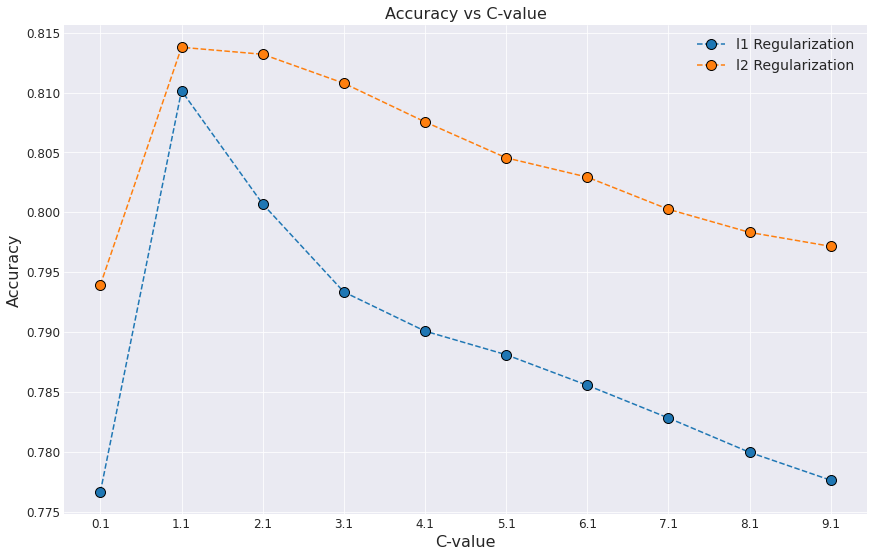

Best models accuracy = 81.38%


In [ ]:
best_model_v1 = plot_scores(Xtrain_vectorized, Ytrain, c_min = 0.1, c_max = 10.1, step = 1, legend = 'upper right')

0.10
0.30
0.50
0.70
0.90
1.10
1.30
1.50
1.70
1.90
2.10
2.30
2.50


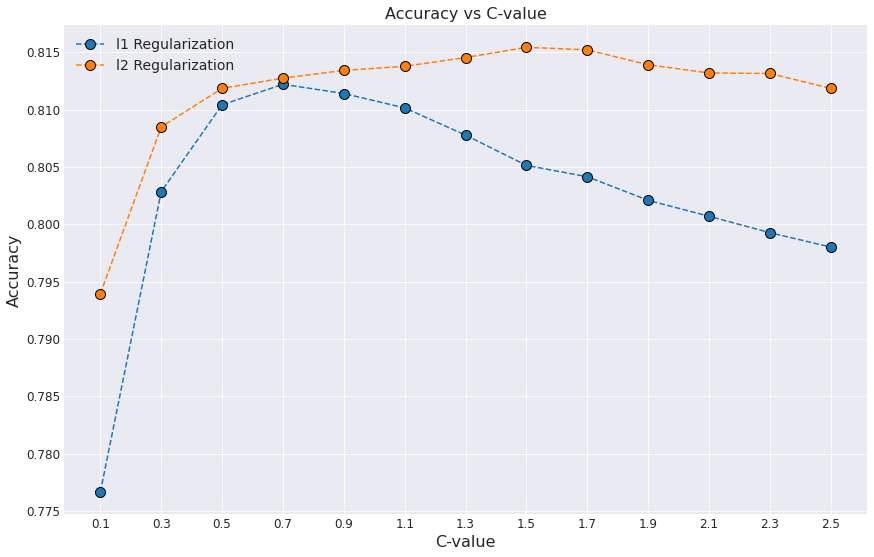

Best models accuracy = 81.54%


In [ ]:
best_model_v2 = plot_scores(Xtrain_vectorized, Ytrain, c_min = 0.1, c_max = 2.7, step = 0.2, legend = 'upper left')

1.20
1.25
1.30
1.35
1.40
1.45
1.50
1.55
1.60
1.65
1.70
1.75
1.80
1.85


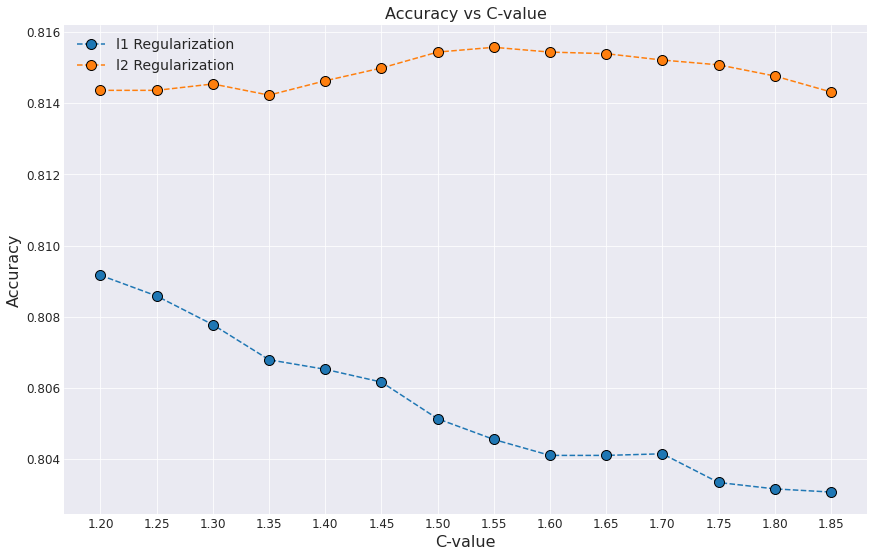

Best models accuracy = 81.56%


In [ ]:
best_model_v3 = plot_scores(Xtrain_vectorized, Ytrain, c_min = 1.2, c_max = 1.9, step = 0.05, legend = 'upper left')

In [ ]:
final_model = best_model_v3
final_model.get_params()

{'C': 1.55,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

**Fit best model on whole training set**

In [ ]:
final_model.fit(Xtrain_vectorized, Ytrain)

LinearSVC(C=1.55, loss='hinge', random_state=0)

**Most important features of the given model**

In [ ]:
def plot_top_n_features(n, model, vectorizer ):
    
    plt.suptitle("Feature Weights")

    plt.subplot(1,2,1)
    plt.title("anti-vaccination")
    pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out()).nsmallest(n).plot(kind='barh').invert_yaxis()
    plt.xlabel('weight')

    plt.subplot(1,2,2)
    plt.title("pro-vaccination")
    pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out()).nlargest(n).plot(kind='barh').invert_yaxis()
    plt.xlabel('weight')
    
    plt.tight_layout()

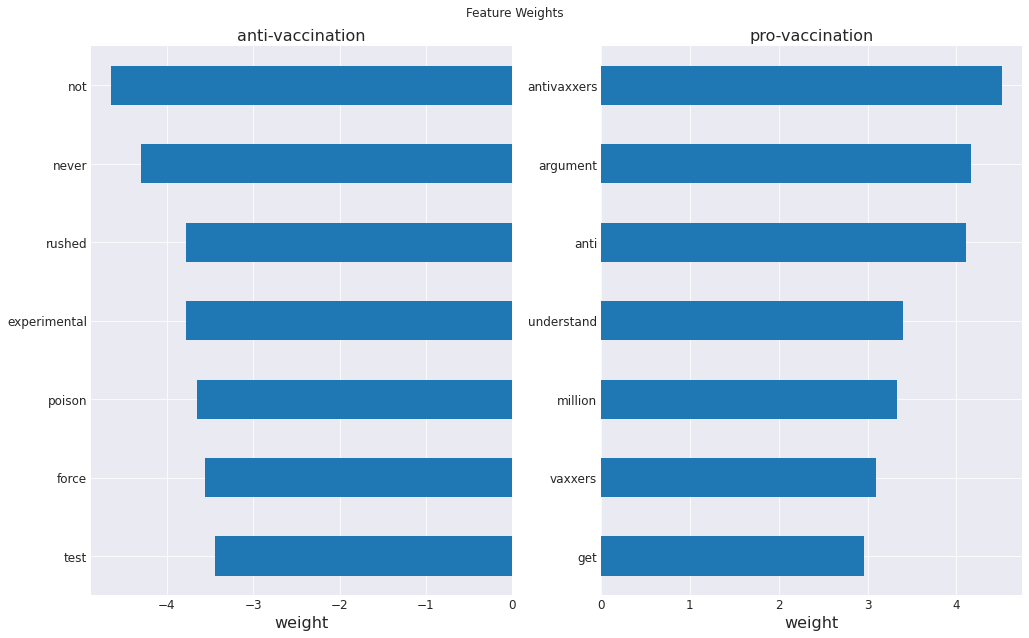

In [ ]:
plot_top_n_features(7, final_model, vectorizer)

**Final testing**

In [ ]:
Xtest, Ytest_prev = read_documents_product("test_final.tsv")
Ytest = create_label(Ytest_prev)
Ytest[:5]

Annotators agree on 100.00% of the comments.


[1, 1, 0, 0, 0]

In [ ]:
Xtest_vectorized = vectorizer.transform(Xtest)

In [ ]:
def plot_confusion_mx(model, Xtest ,Ytest):
    
    ypredicted = model.predict(Xtest)
    acc = accuracy_score(ypredicted, Ytest)
    cm = confusion_matrix(Ytest, ypredicted)
   
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label')
    plt.title(f'{model}\n Accuracy Score: {acc*100:.2f}')
    
    plt.tight_layout()

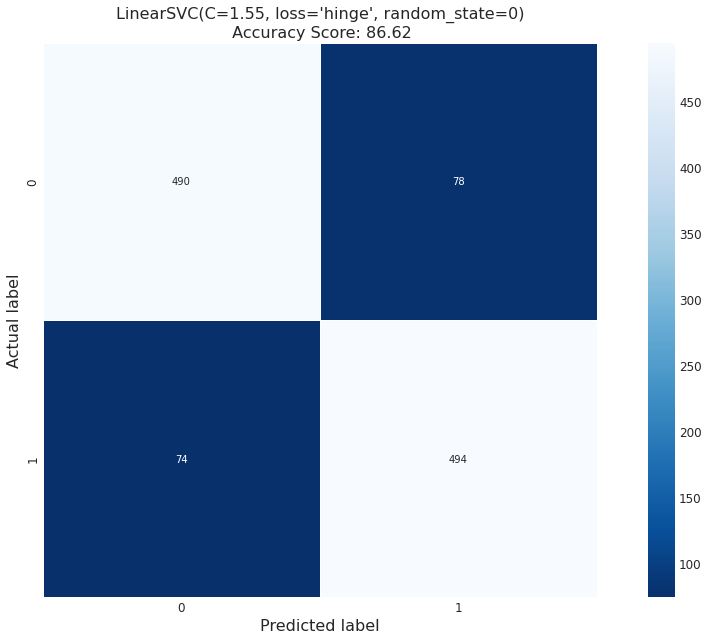

In [ ]:
plot_confusion_mx(final_model, Xtest_vectorized, Ytest)

In [ ]:
def get_scores(model_list, Xtest_vectorized, Ytest):
    acc = []
    f1 = []
    p = []
    r = []

    for model in model_list:
        ypredicted = model.predict(Xtest_vectorized)
        acc.append(accuracy_score(ypredicted, Ytest))
        f1.append(f1_score(ypredicted, Ytest))
        p.append(precision_score(ypredicted, Ytest))
        r.append(recall_score(ypredicted, Ytest))

    return pd.DataFrame(data={'classifier':model_list, 'accuracy':acc, 'f1':f1, 'precision':p, 'recall':r})

In [ ]:
get_scores([final_model], Xtest_vectorized, Ytest)

,classifier,accuracy,f1,precision,recall
0,"LinearSVC(C=1.55, loss='hinge', random_state=0)",0.866197,0.866667,0.869718,0.863636


**Comment on wrongly classified comments**

In [ ]:
def get_wrong_pred(Xtest_vectorized, Xtest, Ytest):

    Ytest_pred = final_model.predict(Xtest_vectorized)

    wrong_pred = pd.DataFrame(data = {'Xtest' : Xtest, 'Ytest' : Ytest, 'Ytest_pred' : Ytest_pred})
    wrong_pred = wrong_pred[wrong_pred.Ytest != wrong_pred.Ytest_pred]
    
    return wrong_pred

In [ ]:
df_wrong_pred = get_wrong_pred(Xtest_vectorized, Xtest, Ytest)
df_wrong_pred

,Xtest,Ytest,Ytest_pred
0,I dont know whats in it As if they know what...,1,0
4,Vaccines are saving lives meanwhile romania b...,0,1
23,A good friend is recovering after covid havin...,1,0
32,About 4 months ago I had COVID 19 I just got...,0,1
38,All I can say is wow,1,0
...,...,...,...
1102,the vaccine is developed by a trusted company,1,0
1104,theres a 0 0000000001 chance that I will chok...,1,0
1119,vaccines can resist the harm caused by the new...,1,0
1128,“Anti vaxers” are just more intelligent than t...,0,1


In [ ]:
# Anti vaccination comments
wrong_pred_0 = df_wrong_pred[df_wrong_pred['Ytest']==0]['Xtest'].to_list()
# Pro vaccination comments
wrong_pred_1 = df_wrong_pred[df_wrong_pred['Ytest']==1]['Xtest'].to_list()

# Top 100 anti and pro vaccination words
anti_words = pd.Series(final_model.coef_[0], index=vectorizer.get_feature_names_out()).nsmallest(100).index.to_list()
pro_words = pd.Series(final_model.coef_[0], index=vectorizer.get_feature_names_out()).nlargest(100).index.to_list()

In [ ]:
c1 = Counter([any(word in comment for word in pro_words) for comment in wrong_pred_0])
c2 = Counter([any(word in comment for word in anti_words) for comment in wrong_pred_1])

print(f"There were pro vaccination words in {c1[True]} ({(c1[True] / (c1[True]+c1[False]) *100):.2f} %) anti vaccination comments")
print(f"There were anti vaccination words in {c2[True]} ({(c2[True] / (c2[True]+c2[False]) *100):.2f} %) pro vaccination comments")

There were pro vaccination words in 61 (78.21 %) anti vaccination comments
There were anti vaccination words in 56 (75.68 %) pro vaccination comments


In [ ]:
pro_in_0 = np.mean([n/l*100 for n,l in
                   zip([sum(word in comment for word in pro_words) for comment in wrong_pred_0], # number of pro words in anti vaccination comments
                        [len(comment.split()) for comment in wrong_pred_0])]) # length of comments

anti_in_1 = np.mean([n/l*100 for n,l in
                   zip([sum(word in comment for word in anti_words) for comment in wrong_pred_1], # number of anti words in pro vaccination comments
                        [len(comment.split()) for comment in wrong_pred_1])]) # length of comments

print(f"On average an anti vaccination comment consisted of {pro_in_0:.2f} % pro words")
print(f"On average a pro vaccination comment consisted of {anti_in_1:.2f} % anti words")

On average an anti vaccination comment consisted of 7.26 % pro words
On average a pro vaccination comment consisted of 10.39 % anti words
